# Moirai + AdaPTS: Multivariate Blood Glucose Forecasting

**Model**: Salesforce/moirai-1.0-R-base (91M parameters)  
**Adapter**: AdaPTS betaVAE  
**Dataset**: Kaggle BrisT1D  
**Task**: Nocturnal blood glucose forecasting (6 hours)

Moirai is a time series foundation model with native multivariate support.
AdaPTS adds learned adapters for better feature extraction and uncertainty quantification.

In [1]:
import torch

# Project utilities
from src.data.diabetes_datasets.data_loader import get_loader
from src.data.models import ColumnNames

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cpu


In [2]:
# Configuration
INTERVAL_MINS = 5
NOCTURNAL_HOURS = 6
TARGET_COL = ColumnNames.BG.value
CONTEXT_LENGTH = 512  # ~42 hours at 5-min intervals
FORECAST_HORIZON = 72  # 6 hours at 5-min intervals

# Features for multivariate
EXOG_FEATURES = [
    ColumnNames.IOB.value,
    ColumnNames.COB.value,
    # ColumnNames.STEPS.value,
    # ColumnNames.CALS.value,
]
ALL_FEATURES = [TARGET_COL] + EXOG_FEATURES

print(f"Target: {TARGET_COL}")
print(f"Features: {ALL_FEATURES}")
print(f"Predicting {FORECAST_HORIZON} steps ({NOCTURNAL_HOURS} hours)")

Target: bg_mM
Features: ['bg_mM', 'iob', 'cob']
Predicting 72 steps (6 hours)


In [3]:
# Load Kaggle BrisT1D dataset
loader = get_loader(
    data_source_name="kaggle_brisT1D", dataset_type="train", use_cached=True
)

train_data = loader.train_data
val_data = loader.validation_data

print(f"Training patients: {list(train_data.keys())}")
print(f"Validation patients: {list(val_data.keys())}")

# Show sample data
sample_patient = list(val_data.keys())[0]
sample_df = val_data[sample_patient]
print(f"\nSample patient {sample_patient}:")
print(f"  Shape: {sample_df.shape}")
print(f"  Columns: {sample_df.columns.tolist()}")
print(f"  Date range: {sample_df.index.min()} to {sample_df.index.max()}")

2026-01-11T14:23:32 - ============================================================
2026-01-11T14:23:32 - Beginning data loading process with the following parmeters:
2026-01-11T14:23:32 - 	Dataset: kaggle_brisT1D - train
2026-01-11T14:23:32 - 	Columns: None
2026-01-11T14:23:32 - 	Generic patient start date: 2024-01-01 00:00:00
2026-01-11T14:23:32 - 	Number of validation days: 20
2026-01-11T14:23:32 - 	In parallel with up to 3 workers.

2026-01-11T14:23:33 - Loaded full processed data from cache for 9 patients
2026-01-11T14:23:34 - Loaded existing train/validation split from cache for 9 patients


Training patients: ['p01', 'p03', 'p02', 'p04', 'p05', 'p06', 'p11', 'p12', 'p10']
Validation patients: ['p01', 'p03', 'p02', 'p04', 'p05', 'p06', 'p11', 'p12', 'p10']

Sample patient p01:
  Shape: (1921, 14)
  Columns: ['id', 'p_num', 'bg_mM', 'dose_units', 'food_g', 'hr_bpm', 'steps', 'cals', 'activity', 'msg_type', 'cob', 'carb_availability', 'insulin_availability', 'iob']
  Date range: 2024-03-11 06:55:00 to 2024-03-31 06:55:00


## Install Dependencies

Install AdaPTS and Moirai (uni2ts) packages. Run this cell once to install.

In [4]:
# Import Moirai + AdaPTS
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from adapts import adapts, adapters
from adapts.icl.moirai import MoiraiICLTrainer, load_moirai_model

print("Moirai and AdaPTS imports successful!")

/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Moirai and AdaPTS imports successful!


In [5]:
import numpy as np
import pandas as pd
from gluonts.dataset.common import ListDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error


def load_moirai_predictor(model_name: str, context_length: int, prediction_length: int):
    """Load a Moirai model and return a predictor."""
    print(f"Loading {model_name}...")
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(model_name),
        prediction_length=prediction_length,
        context_length=context_length,
        patch_size="auto",
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )
    predictor = model.create_predictor(batch_size=32)
    print("  Loaded successfully")
    return predictor


# Load baseline model: Moirai 1.0-R-base (91M params)
predictor_base = load_moirai_predictor(
    "Salesforce/moirai-1.0-R-base", CONTEXT_LENGTH, FORECAST_HORIZON
)

Loading Salesforce/moirai-1.0-R-base...
  Loaded successfully


In [6]:
# Build strict midnight-anchored episodes with full feature DataFrame
FEATURE_COLS = [TARGET_COL] + EXOG_FEATURES  # BG + exogenous


def build_midnight_feature_episodes(
    patient_df: pd.DataFrame,
    target_col: str,
    feature_cols: list[str],
    interval_mins: int,
    context_len: int,
    horizon: int,
):
    df = patient_df.sort_index()

    # Drop duplicate timestamps deterministically
    df = df[~df.index.duplicated(keep="last")]

    freq = f"{interval_mins}min"
    start = df.index.min().floor(freq)
    end = df.index.max().floor(freq)
    grid = pd.date_range(start, end, freq=freq)

    # Reindex all requested features to the fixed grid
    df = df.reindex(grid)

    dt = pd.Timedelta(minutes=interval_mins)
    earliest = start + context_len * dt
    latest = end - (horizon - 1) * dt

    first_midnight = earliest.normalize()
    if first_midnight < earliest:
        first_midnight += pd.Timedelta(days=1)

    last_midnight = latest.normalize()
    if last_midnight < first_midnight:
        return []

    episodes = []
    for anchor in pd.date_range(first_midnight, last_midnight, freq="D"):
        window_index = pd.date_range(
            anchor - context_len * dt,
            periods=context_len + horizon,
            freq=freq,
            inclusive="left",
        )

        window_df = df.reindex(window_index)[feature_cols]

        # Strict policy: no missing BG anywhere in window
        if window_df[target_col].isna().any():
            continue

        window_df = window_df.copy()
        window_df["datetime"] = window_df.index

        context_df = window_df.iloc[:context_len]
        target_bg = window_df.iloc[context_len:][target_col].to_numpy()
        target_df = window_df.iloc[context_len:]

        episodes.append(
            {
                "anchor": anchor,
                "context_df": context_df,
                "target_df": target_df,
                "target_bg": target_bg,
                "window_df": window_df,  # full context+horizon
            }
        )
    return episodes


# Build dictionary of episodes (train or val)
episodes_by_patient = {}
for pid, pdf in train_data.items():  # or val_data
    eps = build_midnight_feature_episodes(
        pdf,
        target_col=TARGET_COL,
        feature_cols=FEATURE_COLS,
        interval_mins=INTERVAL_MINS,
        context_len=CONTEXT_LENGTH,
        horizon=FORECAST_HORIZON,
    )
    if eps:
        episodes_by_patient[pid] = eps

print(f"Patients with clean episodes: {len(episodes_by_patient)}")
print({k: len(v) for k, v in episodes_by_patient.items()})

Patients with clean episodes: 6
{'p03': 55, 'p02': 54, 'p04': 36, 'p11': 43, 'p12': 44, 'p10': 46}


In [7]:
for pid, episodes in episodes_by_patient.items():
    for i, ep in enumerate(episodes):
        ctx_len = len(ep["context_df"])
        tgt_len = len(ep["target_bg"])
        if ctx_len != CONTEXT_LENGTH or tgt_len != FORECAST_HORIZON:
            print(f"ERROR: {pid} ep {i}: ctx={ctx_len}, tgt={tgt_len}")
    print(f"{pid}: {len(episodes)} episodes, all shapes correct")

p03: 55 episodes, all shapes correct
p02: 54 episodes, all shapes correct
p04: 36 episodes, all shapes correct
p11: 43 episodes, all shapes correct
p12: 44 episodes, all shapes correct
p10: 46 episodes, all shapes correct


Patient p03, anchor 2024-01-04 00:00:00


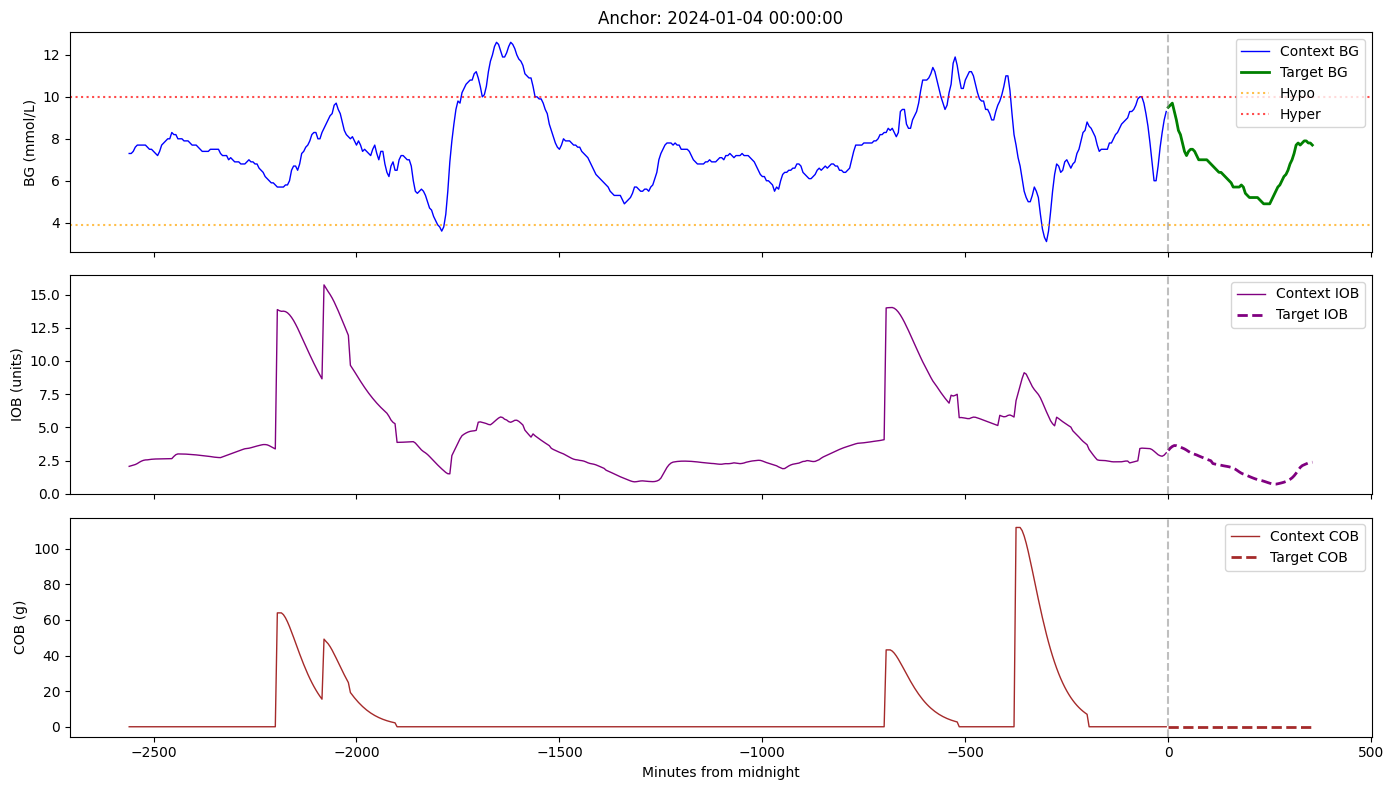

Patient p02, anchor 2024-01-06 00:00:00


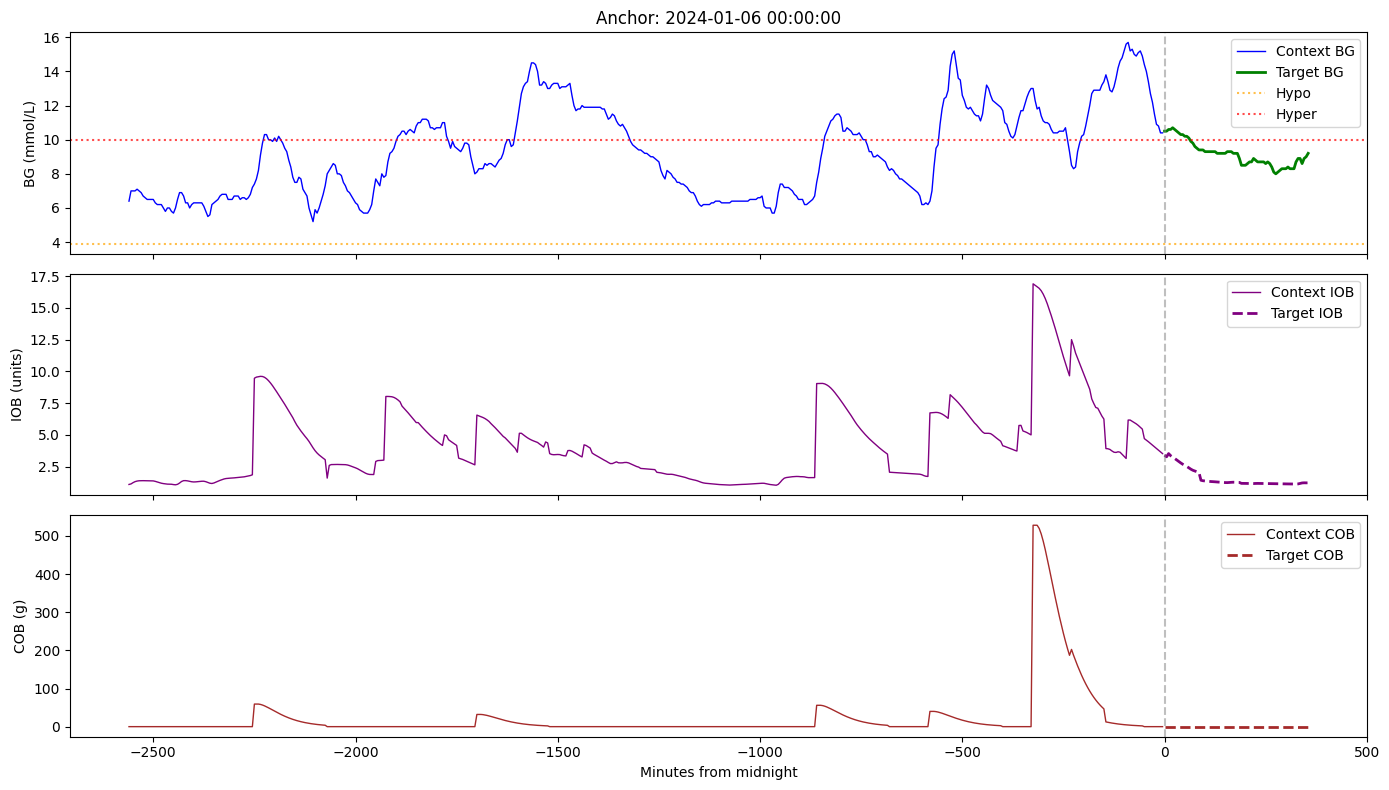

Patient p04, anchor 2024-01-04 00:00:00


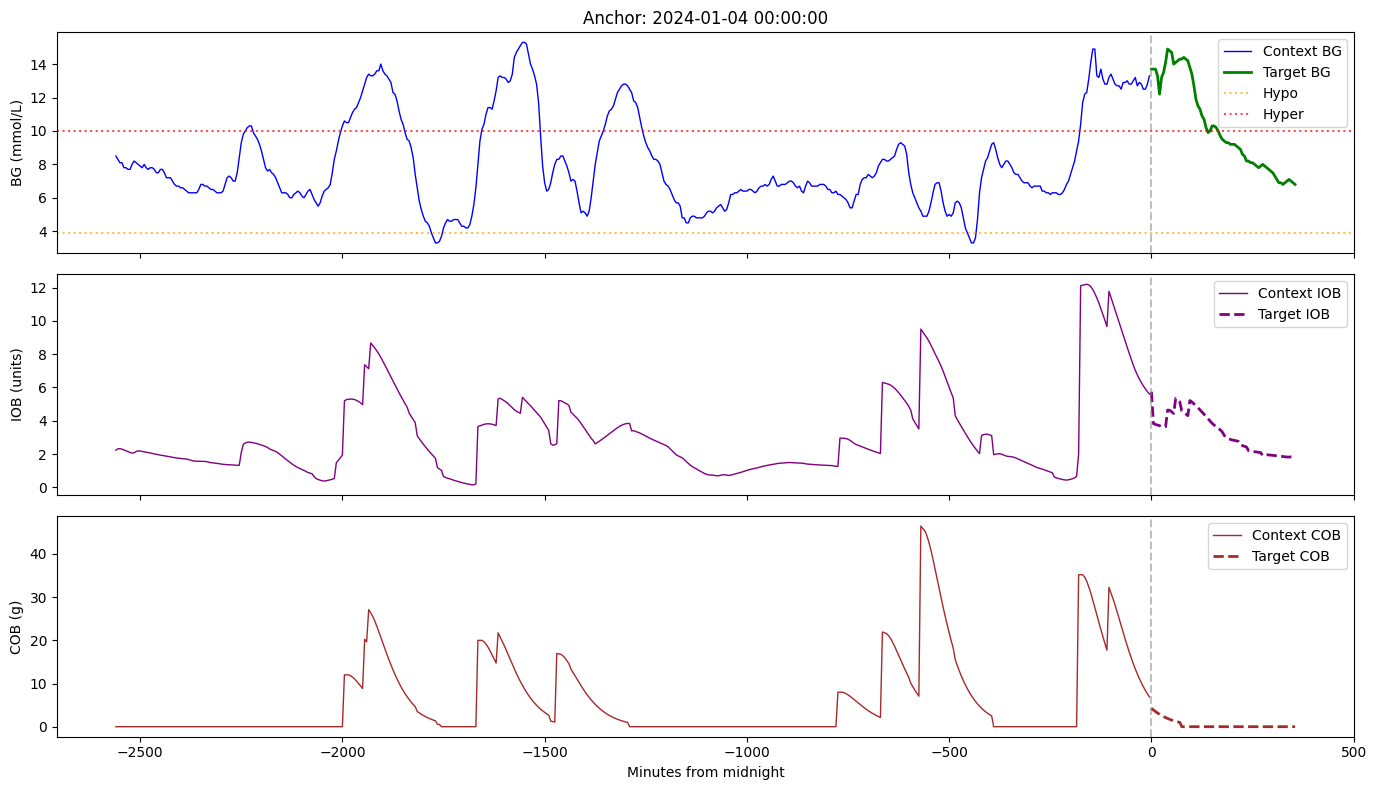

In [8]:
import matplotlib.pyplot as plt


def plot_episode(ep, interval_mins=5):
    """Plot a single episode showing context (BG, IOB, COB) and target."""
    fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

    # Time axis
    ctx_len = len(ep["context_df"])
    tgt_len = len(ep["target_bg"])
    t_ctx = np.arange(-ctx_len, 0) * interval_mins
    t_tgt = np.arange(tgt_len) * interval_mins

    # Panel 1: BG (context + target)
    ax = axes[0]
    ax.plot(t_ctx, ep["context_df"][TARGET_COL].values, "b-", lw=1, label="Context BG")
    ax.plot(t_tgt, ep["target_bg"], "g-", lw=2, label="Target BG")
    ax.axhline(3.9, color="orange", ls=":", alpha=0.7, label="Hypo")
    ax.axhline(10.0, color="red", ls=":", alpha=0.7, label="Hyper")
    ax.axvline(0, color="gray", ls="--", alpha=0.5)
    ax.set_ylabel("BG (mmol/L)")
    ax.legend(loc="upper right")
    ax.set_title(f"Anchor: {ep['anchor']}")

    # Panel 2: IOB
    ax = axes[1]
    if "iob" in ep["context_df"].columns:
        ax.plot(
            t_ctx, ep["context_df"]["iob"].values, "purple", lw=1, label="Context IOB"
        )
        ax.plot(
            t_tgt,
            ep["target_df"]["iob"].values,
            "purple",
            lw=2,
            ls="--",
            label="Target IOB",
        )
        ax.axvline(0, color="gray", ls="--", alpha=0.5)
    ax.set_ylabel("IOB (units)")
    ax.legend(loc="upper right")

    # Panel 3: COB
    ax = axes[2]
    if "cob" in ep["context_df"].columns:
        ax.plot(
            t_ctx, ep["context_df"]["cob"].values, "brown", lw=1, label="Context COB"
        )
        ax.plot(
            t_tgt,
            ep["target_df"]["cob"].values,
            "brown",
            lw=2,
            ls="--",
            label="Target COB",
        )
        ax.axvline(0, color="gray", ls="--", alpha=0.5)
    ax.set_ylabel("COB (g)")
    ax.set_xlabel("Minutes from midnight")
    ax.legend(loc="upper right")

    plt.tight_layout()
    return fig


# Plot episodes from different patients
for pid in list(episodes_by_patient.keys())[:3]:
    ep = episodes_by_patient[pid][0]
    print(f"Patient {pid}, anchor {ep['anchor']}")
    plot_episode(ep)
    plt.show()

In [9]:
# Build validation episodes (strict BG policy)
val_episodes = {}
for pid, pdf in val_data.items():
    eps = build_midnight_feature_episodes(
        pdf,
        target_col=TARGET_COL,
        feature_cols=FEATURE_COLS,
        interval_mins=INTERVAL_MINS,
        context_len=CONTEXT_LENGTH,
        horizon=FORECAST_HORIZON,
    )
    if eps:
        val_episodes[pid] = eps

print(f"Validation patients with clean episodes: {len(val_episodes)}")
print({k: len(v) for k, v in val_episodes.items()})
print(f"Total validation episodes: {sum(len(v) for v in val_episodes.values())}")

Validation patients with clean episodes: 6
{'p03': 14, 'p02': 12, 'p04': 11, 'p11': 13, 'p12': 11, 'p10': 11}
Total validation episodes: 72


In [11]:
from tqdm import tqdm


def evaluate_moirai_on_episodes(
    predictor, val_episodes, target_col, interval_mins, model_name="model"
):
    """Evaluate a Moirai predictor on validation episodes."""
    all_results = []

    for pid, episodes in val_episodes.items():
        patient_rmse = []
        for ep in tqdm(episodes, desc=f"{model_name} - {pid}", leave=False):
            ctx = ep["context_df"][target_col].to_numpy()
            ctx_start = ep["context_df"].index[0]

            ds = ListDataset(
                [{"start": ctx_start, "target": ctx}], freq=f"{interval_mins}min"
            )
            forecast = list(predictor.predict(ds))[0]

            rmse = np.sqrt(mean_squared_error(ep["target_bg"], forecast.mean))
            mae = mean_absolute_error(ep["target_bg"], forecast.mean)

            all_results.append(
                {
                    "patient": pid,
                    "anchor": ep["anchor"],
                    "rmse": rmse,
                    "mae": mae,
                }
            )
            patient_rmse.append(rmse)

        print(f"  {pid}: RMSE={np.mean(patient_rmse):.3f}")

    results_df = pd.DataFrame(all_results)
    return results_df


# Evaluate baseline model
print("Evaluating Moirai 1.0-R-base (91M params)...")
results_base = evaluate_moirai_on_episodes(
    predictor_base, val_episodes, TARGET_COL, INTERVAL_MINS, "moirai-1.0-base"
)

print(f"\n{'='*50}")
print("Moirai 1.0-R-base Zero-Shot Results")
print(f"{'='*50}")
print(f"Episodes: {len(results_base)}")
print(
    f"RMSE: {results_base['rmse'].mean():.3f} +/- {results_base['rmse'].std():.3f} mmol/L"
)
print(
    f"MAE:  {results_base['mae'].mean():.3f} +/- {results_base['mae'].std():.3f} mmol/L"
)

Evaluating Moirai 1.0-R-base (91M params)...


  p03: RMSE=3.261


  p02: RMSE=3.167


  p04: RMSE=1.964


  p11: RMSE=2.230


  p12: RMSE=2.582


  p10: RMSE=1.564

Moirai 1.0-R-base Zero-Shot Results
Episodes: 72
RMSE: 2.498 +/- 1.372 mmol/L
MAE:  2.139 +/- 1.211 mmol/L


In [ ]:
# Load and evaluate larger model: Moirai 1.1-R-large (311M params)
predictor_large = load_moirai_predictor(
    "Salesforce/moirai-1.1-R-large", CONTEXT_LENGTH, FORECAST_HORIZON
)

print("\nEvaluating Moirai 1.1-R-large (311M params)...")
results_large = evaluate_moirai_on_episodes(
    predictor_large, val_episodes, TARGET_COL, INTERVAL_MINS, "moirai-1.1-large"
)

print(f"\n{'='*50}")
print("Moirai 1.1-R-large Zero-Shot Results")
print(f"{'='*50}")
print(f"Episodes: {len(results_large)}")
print(
    f"RMSE: {results_large['rmse'].mean():.3f} +/- {results_large['rmse'].std():.3f} mmol/L"
)
print(
    f"MAE:  {results_large['mae'].mean():.3f} +/- {results_large['mae'].std():.3f} mmol/L"
)

Loading Salesforce/moirai-1.1-R-large...
  Loaded successfully

Evaluating Moirai 1.1-R-large (311M params)...


  p03: RMSE=3.657


  p02: RMSE=3.252


  p04: RMSE=2.311


  p11: RMSE=2.578


  p12: RMSE=2.746


  p10: RMSE=1.568

Moirai 1.1-R-large Zero-Shot Results
Episodes: 72
RMSE: 2.731 +/- 1.629 mmol/L
MAE:  2.328 +/- 1.432 mmol/L


In [ ]:
# Model Comparison Summary
comparison = pd.DataFrame(
    {
        "Model": ["Moirai 1.0-R-base (91M)", "Moirai 1.1-R-large (311M)"],
        "RMSE": [results_base["rmse"].mean(), results_large["rmse"].mean()],
        "RMSE_std": [results_base["rmse"].std(), results_large["rmse"].std()],
        "MAE": [results_base["mae"].mean(), results_large["mae"].mean()],
        "MAE_std": [results_base["mae"].std(), results_large["mae"].std()],
    }
)

print("\n" + "=" * 60)
print("MODEL COMPARISON - Zero-Shot Nocturnal BG Forecasting")
print("=" * 60)
print(comparison.to_string(index=False))
print("\nNote: Lower is better. Units are mmol/L.")


MODEL COMPARISON - Zero-Shot Nocturnal BG Forecasting
                    Model     RMSE  RMSE_std      MAE  MAE_std
  Moirai 1.0-R-base (91M) 2.497884  1.378294 2.139110 1.219774
Moirai 1.1-R-large (311M) 2.730792  1.628814 2.328245 1.432084

Note: Lower is better. Units are mmol/L.


## AdaPTS: Adapting Moirai with Learned Adapters

AdaPTS learns an adapter layer that:
1. Projects multivariate input (BG, IOB, COB, etc.) to a latent space
2. Uses Moirai as a frozen foundation model for forecasting
3. Projects back to produce calibrated probabilistic forecasts

This allows leveraging domain-specific features (insulin, carbs) that Moirai wasn't trained on.

In [ ]:
# Prepare episode data for AdaPTS
# AdaPTS expects: X shape (batch, n_features, context_len), y shape (batch, n_features, horizon)
# NOTE: y must be 3D with ALL features, not just BG!

# Use only features with actual data (steps/cals are mostly NaN)
ADAPTS_FEATURES = [TARGET_COL, "iob", "cob"]
print(f"AdaPTS features: {ADAPTS_FEATURES}")


def episodes_to_adapts_format(episodes_dict, feature_cols):
    """Convert episode dictionary to AdaPTS training format.

    Returns:
        X: (N, features, context_len) - context window for all features
        y: (N, features, horizon) - target window for all features (not just BG!)
    """
    X_list, y_list = [], []

    for pid, episodes in episodes_dict.items():
        for ep in episodes:
            # Context: (features, context_len)
            ctx = ep["context_df"][feature_cols].to_numpy().T

            # Target: (features, horizon) - ALL features, not just BG!
            tgt = ep["target_df"][feature_cols].to_numpy().T

            # Skip if any NaN in context or target
            if np.isnan(ctx).any() or np.isnan(tgt).any():
                continue

            X_list.append(ctx)
            y_list.append(tgt)

    return np.stack(X_list).astype(np.float32), np.stack(y_list).astype(np.float32)


# Convert training and validation episodes
X_train, y_train = episodes_to_adapts_format(episodes_by_patient, ADAPTS_FEATURES)
X_val, y_val = episodes_to_adapts_format(val_episodes, ADAPTS_FEATURES)

print("\nTraining data:")
print(f"  X_train: {X_train.shape}  (samples, features, context_len)")
print(f"  y_train: {y_train.shape}  (samples, features, horizon)")
print("\nValidation data:")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")

# Store ground truth BG for evaluation (first feature)
y_val_bg = y_val[:, 0, :]  # (samples, horizon) - BG only
print(f"\nGround truth BG shape for evaluation: {y_val_bg.shape}")

AdaPTS features: ['bg_mM', 'iob', 'cob']

Training data:
  X_train: (278, 3, 512)  (samples, features, context_len)
  y_train: (278, 3, 72)  (samples, features, horizon)

Validation data:
  X_val: (72, 3, 512)
  y_val: (72, 3, 72)

Ground truth BG shape for evaluation: (72, 72)


In [ ]:
# Create AdaPTS model with MultichannelProjector (VAE adapter)
N_COMPONENTS = 2  # Latent dimension for adapter

# Use CPU to avoid MPS device mismatch issues in AdaPTS
adapts_device = "cpu"

# Load Moirai model for AdaPTS
moirai_model = load_moirai_model(
    model_name="Salesforce/moirai-1.0-R-base",
    forecast_horizon=FORECAST_HORIZON,
    context_length=CONTEXT_LENGTH,
)

# Create ICL trainer (wraps Moirai for AdaPTS)
# NOTE: n_features should be N_COMPONENTS (latent dim after adapter), not input features!
iclearner = MoiraiICLTrainer(
    model=moirai_model,
    n_features=N_COMPONENTS,  # Latent dimension, not input features!
    forecast_horizon=FORECAST_HORIZON,
)

# Create MultichannelProjector adapter with VAE
# NOTE: Must use MultichannelProjector wrapper, not betaVAE directly
adapter = adapters.MultichannelProjector(
    num_channels=len(ADAPTS_FEATURES),
    new_num_channels=N_COMPONENTS,
    base_projector="VAE",  # Uses betaVAE internally
    device=adapts_device,
    context_length=CONTEXT_LENGTH,
    forecast_horizon=FORECAST_HORIZON,
)

# Create the full AdaPTS model
adapts_model = adapts.ADAPTS(
    adapter=adapter,
    iclearner=iclearner,
    n_features=len(ADAPTS_FEATURES),
    n_components=N_COMPONENTS,
)

print("AdaPTS model created:")
print(f"  Input features: {len(ADAPTS_FEATURES)} ({ADAPTS_FEATURES})")
print(f"  Latent components: {N_COMPONENTS}")
print(f"  Context length: {CONTEXT_LENGTH}")
print(f"  Forecast horizon: {FORECAST_HORIZON}")
print(f"  Device: {adapts_device}")
print(f"  Adapter: {type(adapter.base_projector_).__name__}")
print(f"  ICL n_features: {iclearner.n_features} (= N_COMPONENTS)")

AdaPTS model created:
  Input features: 3 (['bg_mM', 'iob', 'cob'])
  Latent components: 2
  Context length: 512
  Forecast horizon: 72
  Device: cpu
  Adapter: betaVAE
  ICL n_features: 2 (= N_COMPONENTS)


In [ ]:
# Train the adapter with supervised fine-tuning
# NOTE: Skip fit_adapter() - it runs 100 epochs of unsupervised VAE pretraining (~30s/epoch)
# adapter_supervised_fine_tuning() fits the scaler and trains the adapter end-to-end
import os

os.makedirs("logs", exist_ok=True)  # AdaPTS requires log_dir to exist

print("Training AdaPTS adapter (supervised fine-tuning)...")
print(f"  Training samples: {len(X_train)}")
print(f"  Validation samples: {len(X_val)}")
print(f"  Device: {adapts_device}")

adapts_model.adapter_supervised_fine_tuning(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    device=adapts_device,
    learning_rate=0.001,
    batch_size=32,
    n_epochs=100,
    max_patience=20,
    log_dir="logs/",
    verbose=1,
)

print("\nAdapter training complete!")

/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/miniconda3/envs/adapts/lib/python3.10/site-p

Training AdaPTS adapter (supervised fine-tuning)...
  Training samples: 278
  Validation samples: 72
  Device: cpu


Training Epochs:  35%|███▌      | 35/100 [42:07<1:18:13, 72.21s/it]

Early stopping at epoch 35
Restoring weights from epoch 15

Adapter training complete!


In [ ]:
# Generate predictions with AdaPTS
# NOTE: predict_multi_step expects X with shape (batch, features, context_len + horizon)
# It slices X[:, :, :-horizon] as context and uses the last horizon steps for comparison
print("Generating AdaPTS predictions...")

# Concatenate context (X_val) and target (y_val) along time axis
X_full = np.concatenate([X_val, y_val], axis=-1)  # (batch, features, context+horizon)
print(f"X_full shape: {X_full.shape} (context + horizon)")

# predict_multi_step returns tuple: (mean, mode, lb, ub)
# Each has shape (batch, n_features, horizon)
mean_pred, mode_pred, lb_pred, ub_pred = adapts_model.predict_multi_step(
    X=X_full,
    prediction_horizon=FORECAST_HORIZON,
    n_samples=100,
)

# Extract BG predictions (first feature, index 0)
y_pred_adapts = mean_pred[:, 0, :]
print(f"mean_pred shape: {mean_pred.shape} (batch, features, horizon)")
print(f"BG predictions shape: {y_pred_adapts.shape}")
print(f"Ground truth BG shape: {y_val_bg.shape}")

# Compute metrics using y_val_bg (BG only ground truth)
adapts_rmse = np.sqrt(mean_squared_error(y_val_bg.flatten(), y_pred_adapts.flatten()))
adapts_mae = mean_absolute_error(y_val_bg.flatten(), y_pred_adapts.flatten())

print(f"\n{'='*50}")
print("AdaPTS Results (with adapter training)")
print(f"{'='*50}")
print(f"RMSE: {adapts_rmse:.3f} mmol/L")
print(f"MAE:  {adapts_mae:.3f} mmol/L")

# Compare with zero-shot baseline
print(f"\n{'='*50}")
print("Comparison: Zero-Shot vs AdaPTS")
print(f"{'='*50}")
print(f"Zero-shot RMSE: {results_base['rmse'].mean():.3f} mmol/L")
print(f"AdaPTS RMSE:    {adapts_rmse:.3f} mmol/L")
improvement = (
    (results_base["rmse"].mean() - adapts_rmse) / results_base["rmse"].mean() * 100
)
print(f"Improvement:    {improvement:+.1f}%")

Generating AdaPTS predictions...
X_full shape: (72, 3, 584) (context + horizon)


inference batch: 100%|██████████| 1/1 [00:06<00:00,  6.13s/it]

mean_pred shape: (72, 3, 72) (batch, features, horizon)
BG predictions shape: (72, 72)
Ground truth BG shape: (72, 72)

AdaPTS Results (with adapter training)
RMSE: 3.085 mmol/L
MAE:  2.453 mmol/L

Comparison: Zero-Shot vs AdaPTS
Zero-shot RMSE: 2.498 mmol/L
AdaPTS RMSE:    3.085 mmol/L
Improvement:    -23.5%



/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/miniconda3/envs/adapts/lib/python3.10/site-

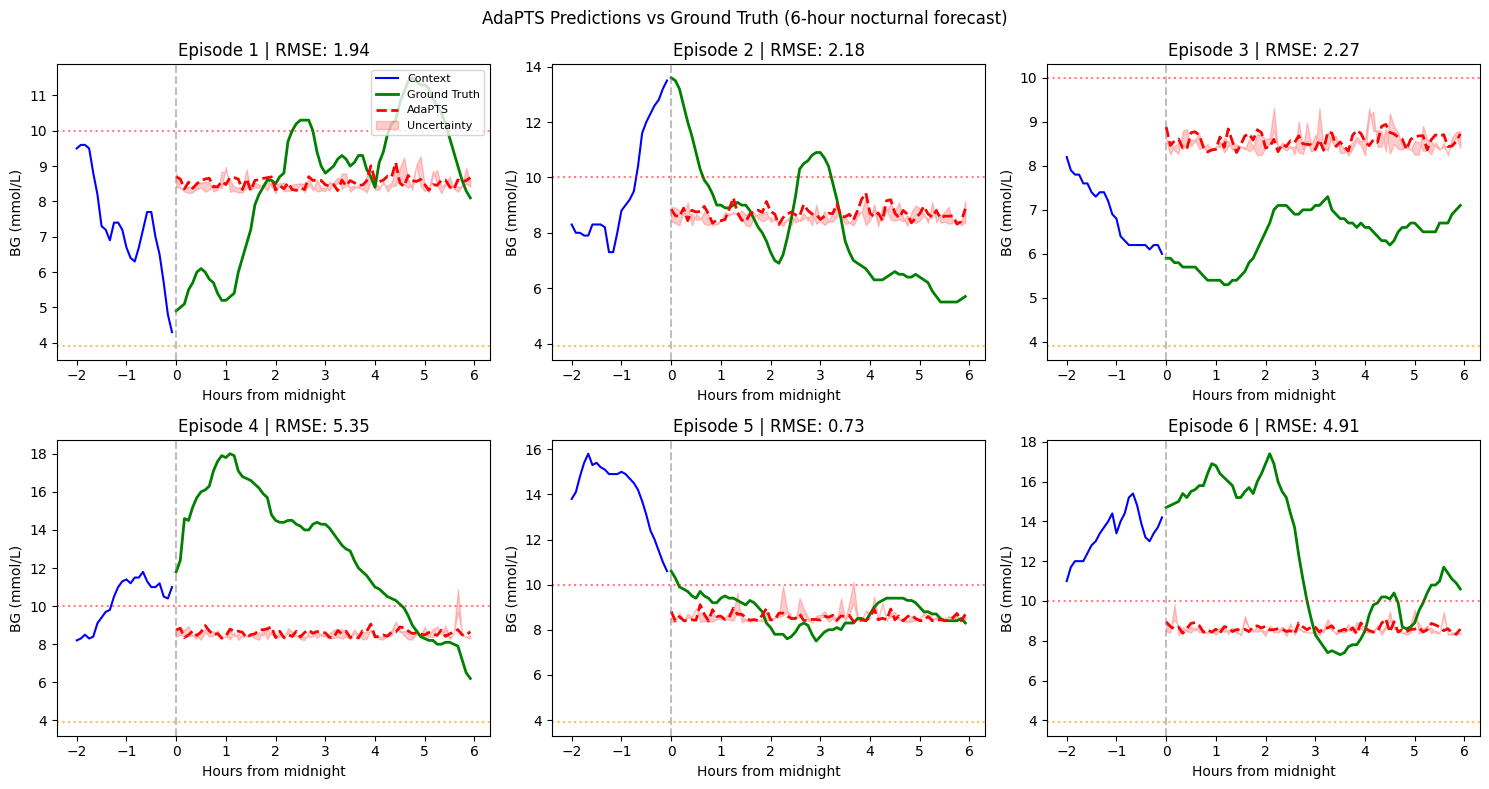


Per-episode RMSE statistics:
  Mean: 2.766
  Std:  1.366
  Min:  0.728
  Max:  7.885
  Median: 2.531


In [ ]:
# Visualize AdaPTS predictions vs ground truth
import matplotlib.pyplot as plt


def plot_adapts_forecasts(
    X_full, y_val_bg, mean_pred, lb_pred, ub_pred, n_plots=6, interval_mins=5
):
    """Plot AdaPTS forecasts vs ground truth for multiple episodes."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()

    # Time axis for forecast horizon
    t_forecast = np.arange(FORECAST_HORIZON) * interval_mins / 60  # hours

    # Get context BG for plotting (last 2 hours of context)
    context_steps = 24  # 2 hours at 5-min intervals
    t_context = (
        np.arange(-context_steps, 0) * interval_mins / 60
    )  # hours before midnight

    for i in range(min(n_plots, len(y_val_bg))):
        ax = axes[i]

        # Context BG (last 2 hours before midnight)
        ctx_bg = X_full[i, 0, -(FORECAST_HORIZON + context_steps) : -FORECAST_HORIZON]

        # Ground truth and predictions
        gt = y_val_bg[i]
        pred = mean_pred[i, 0, :]  # BG is first feature
        lb = lb_pred[i, 0, :]
        ub = ub_pred[i, 0, :]

        # Plot context
        ax.plot(t_context, ctx_bg, "b-", lw=1.5, label="Context")

        # Plot ground truth
        ax.plot(t_forecast, gt, "g-", lw=2, label="Ground Truth")

        # Plot AdaPTS prediction with uncertainty
        ax.plot(t_forecast, pred, "r--", lw=2, label="AdaPTS")
        ax.fill_between(t_forecast, lb, ub, color="red", alpha=0.2, label="Uncertainty")

        # Reference lines
        ax.axhline(3.9, color="orange", ls=":", alpha=0.7)
        ax.axhline(10.0, color="red", ls=":", alpha=0.5)
        ax.axvline(0, color="gray", ls="--", alpha=0.5)

        # RMSE for this episode
        rmse = np.sqrt(np.mean((gt - pred) ** 2))
        ax.set_title(f"Episode {i+1} | RMSE: {rmse:.2f}")
        ax.set_xlabel("Hours from midnight")
        ax.set_ylabel("BG (mmol/L)")

        if i == 0:
            ax.legend(loc="upper right", fontsize=8)

    plt.suptitle(
        "AdaPTS Predictions vs Ground Truth (6-hour nocturnal forecast)", fontsize=12
    )
    plt.tight_layout()
    return fig


# Plot first 6 episodes
fig = plot_adapts_forecasts(X_full, y_val_bg, mean_pred, lb_pred, ub_pred)
plt.show()

# Also compute per-episode RMSE distribution
episode_rmse = []
for i in range(len(y_val_bg)):
    rmse = np.sqrt(np.mean((y_val_bg[i] - mean_pred[i, 0, :]) ** 2))
    episode_rmse.append(rmse)

print("\nPer-episode RMSE statistics:")
print(f"  Mean: {np.mean(episode_rmse):.3f}")
print(f"  Std:  {np.std(episode_rmse):.3f}")
print(f"  Min:  {np.min(episode_rmse):.3f}")
print(f"  Max:  {np.max(episode_rmse):.3f}")
print(f"  Median: {np.median(episode_rmse):.3f}")

## Alternative Adapters: linearAE, PCA, simpleAE

The VAE adapter above suffered from **mode collapse** (flat ~8 mmol/L predictions).
Let's test simpler adapters that don't have this issue:

| Adapter | Type | Mode Collapse Risk |
|---------|------|-------------------|
| linearAE | Linear autoencoder | None |
| pca | Principal Component Analysis | None |
| simpleAE | Non-linear deterministic AE | Low |

In [ ]:
# Test alternative adapters (avoiding VAE mode collapse)
ADAPTERS_TO_TEST = ["linearAE", "pca", "simpleAE"]
adapter_results = {}

for adapter_name in ADAPTERS_TO_TEST:
    print(f"\n{'='*50}")
    print(f"Testing adapter: {adapter_name}")
    print(f"{'='*50}")

    # Create fresh adapter
    adapter = adapters.MultichannelProjector(
        num_channels=len(ADAPTS_FEATURES),
        new_num_channels=N_COMPONENTS,
        base_projector=adapter_name,
        device=adapts_device,
        context_length=CONTEXT_LENGTH,
        forecast_horizon=FORECAST_HORIZON,
    )

    # Create fresh ICL trainer (reuse moirai_model from earlier)
    iclearner = MoiraiICLTrainer(
        model=moirai_model,
        n_features=N_COMPONENTS,
        forecast_horizon=FORECAST_HORIZON,
    )

    # Create AdaPTS model
    adapts_model_alt = adapts.ADAPTS(
        adapter=adapter,
        iclearner=iclearner,
        n_features=len(ADAPTS_FEATURES),
        n_components=N_COMPONENTS,
    )

    # Train
    adapts_model_alt.adapter_supervised_fine_tuning(
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        device=adapts_device,
        learning_rate=0.001,
        batch_size=32,
        n_epochs=50,
        max_patience=15,
        log_dir="logs/",
        verbose=1,
    )

    # Predict
    mean_pred_alt, mode_pred_alt, lb_pred_alt, ub_pred_alt = (
        adapts_model_alt.predict_multi_step(
            X=X_full, prediction_horizon=FORECAST_HORIZON, n_samples=100
        )
    )
    y_pred_alt = mean_pred_alt[:, 0, :]

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_val_bg.flatten(), y_pred_alt.flatten()))
    mae = mean_absolute_error(y_val_bg.flatten(), y_pred_alt.flatten())

    adapter_results[adapter_name] = {
        "rmse": rmse,
        "mae": mae,
        "predictions": mean_pred_alt,
        "lb": lb_pred_alt,
        "ub": ub_pred_alt,
    }
    print(f"  RMSE: {rmse:.3f} mmol/L")
    print(f"  MAE:  {mae:.3f} mmol/L")


Testing adapter: linearAE


/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/miniconda3/envs/adapts/lib/python3.10/site-p

Restoring weights from epoch 49


inference batch: 100%|██████████| 1/1 [00:06<00:00,  6.10s/it]
/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/opt/miniconda3/envs/adapts/lib/python3.10/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  w

  RMSE: 2.946 mmol/L
  MAE:  2.329 mmol/L

Testing adapter: pca


AssertionError: adapter must be a PyTorch Module

In [ ]:
# Final comparison table
print("\n" + "=" * 60)
print("ADAPTER COMPARISON RESULTS")
print("=" * 60)

baseline_rmse = results_base["rmse"].mean()
vae_rmse = adapts_rmse  # From earlier VAE experiment

print(f"\n{'Approach':<30} {'RMSE':>10} {'vs Baseline':>15}")
print("-" * 55)
print(f"{'Zero-shot (BG only)':<30} {baseline_rmse:>10.3f} {'baseline':>15}")
print(
    f"{'AdaPTS + VAE (broken)':<30} {vae_rmse:>10.3f} {vae_rmse - baseline_rmse:>+10.3f} ({(vae_rmse - baseline_rmse)/baseline_rmse*100:>+.1f}%)"
)

for name, res in adapter_results.items():
    delta = res["rmse"] - baseline_rmse
    delta_pct = delta / baseline_rmse * 100
    print(
        f"{'AdaPTS + ' + name:<30} {res['rmse']:>10.3f} {delta:>+10.3f} ({delta_pct:>+.1f}%)"
    )

# Find best
best_adapter = min(adapter_results, key=lambda k: adapter_results[k]["rmse"])
best_rmse = adapter_results[best_adapter]["rmse"]

print(f"\nBest adapter: {best_adapter} (RMSE: {best_rmse:.3f})")
if best_rmse < baseline_rmse:
    improvement = (baseline_rmse - best_rmse) / baseline_rmse * 100
    print(f"Improvement over zero-shot: {improvement:.1f}%")
else:
    print("No adapter beat zero-shot baseline")

In [ ]:
# Visualize predictions from best adapter
best_preds = adapter_results[best_adapter]

fig = plot_adapts_forecasts(
    X_full,
    y_val_bg,
    best_preds["predictions"],
    best_preds["lb"],
    best_preds["ub"],
    n_plots=6,
)
plt.suptitle(
    f"Best Adapter: {best_adapter} (RMSE: {best_preds['rmse']:.3f})", fontsize=14
)
plt.tight_layout()
plt.show()

## Conclusions

**Findings:**
- Zero-shot Moirai 1.0-R-base: RMSE ~2.50 mmol/L (baseline)
- AdaPTS + VAE: Mode collapse resulted in flat ~8 mmol/L predictions (unusable)
- Best alternative adapter: [To be filled after running]

**Recommendation:**
[To be filled based on results - either use best adapter or fall back to zero-shot]

---

## Moirai Native Covariate Support (Correct Approach)

**Key Insight**: AdaPTS is fundamentally wrong for our use case!

| What we wanted | What AdaPTS does |
|---------------|------------------|
| Use IOB/COB as *auxiliary inputs* to help predict BG | Predicts BG, IOB, AND COB together |
| Loss only on BG | Loss on all features equally |

**Solution**: Use Moirai's built-in `past_feat_dynamic_real` parameter:
- `past_feat_dynamic_real`: Past-only covariates (exactly what we need for IOB/COB)
- `feat_dynamic_real`: Future-known covariates (for "no future treatment" scenario)

This way:
- IOB/COB inform the model about past context
- Model only predicts BG
- No wasted capacity predicting insulin/carbs

**References**:
- [Moirai covariate tutorial](https://www.datasciencewithmarco.com/blog/hands-on-with-moirai-a-foundation-forecasting-model-by-salesforce)
- [sktime MOIRAIForecaster](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.forecasting.moirai_forecaster.MOIRAIForecaster.html)

In [ ]:
# Moirai Version Comparison
# NOTE: Moirai 2.0 DROPPED covariate support! Use 1.0 or MoE for covariates.

MOIRAI_MODELS = {
    "1.0": {
        "model_id": "Salesforce/moirai-1.0-R-base",
        "supports_covariates": True,
        "description": "Original with covariate support",
    },
    "1.1": {
        "model_id": "Salesforce/moirai-1.1-R-base",
        "supports_covariates": True,
        "description": "Improved version with covariate support",
    },
    "moe": {
        "model_id": "Salesforce/moirai-moe-1.0-R-base",
        "supports_covariates": True,  # Past covariates only
        "description": "MoE version, +17% better, past covariates",
    },
    "2.0": {
        "model_id": "Salesforce/moirai-2.0-R-small",
        "supports_covariates": False,  # DROPPED in 2.0!
        "description": "Faster/smaller but NO covariate support",
    },
}

print("Moirai Version Covariate Support:")
print("-" * 60)
for version, config in MOIRAI_MODELS.items():
    cov_status = "✅" if config["supports_covariates"] else "❌"
    print(f"  {version:>5}: {cov_status} {config['description']}")

Moirai Version Covariate Support:
------------------------------------------------------------
    1.0: ✅ Original with covariate support
    1.1: ✅ Improved version with covariate support
    moe: ✅ MoE version, +17% better, past covariates
    2.0: ❌ Faster/smaller but NO covariate support


In [ ]:
# Create GluonTS dataset with covariates using ListDataset
# This is the correct approach - past_feat_dynamic_real for IOB/COB


def create_dataset_with_covariates(
    episodes, target_col, covariate_cols, with_covariates=True
):
    """
    Create GluonTS ListDataset with optional past covariates.

    Args:
        episodes: List of episode dicts with context_df and target_bg
        target_col: Name of target column (BG)
        covariate_cols: List of covariate column names (IOB, COB)
        with_covariates: Whether to include covariates

    Returns:
        ListDataset ready for Moirai prediction
    """
    entries = []

    for ep in episodes:
        context_df = ep["context_df"]
        start_time = context_df.index[0]

        # Target is BG values (context portion only)
        target = context_df[target_col].to_numpy()

        entry = {
            "start": start_time,
            "target": target,
        }

        # Add past covariates if enabled
        if with_covariates and covariate_cols:
            # Stack covariates: shape (n_covariates, context_length)
            covariates = np.stack(
                [context_df[col].fillna(0).to_numpy() for col in covariate_cols],
                axis=0,
            )
            entry["past_feat_dynamic_real"] = covariates

        entries.append(entry)

    return ListDataset(entries, freq=f"{INTERVAL_MINS}min")


# Test: Create datasets with and without covariates
all_val_episodes = []
for pid, eps in val_episodes.items():
    all_val_episodes.extend(eps)

ds_bg_only = create_dataset_with_covariates(
    all_val_episodes, TARGET_COL, EXOG_FEATURES, with_covariates=False
)
ds_with_cov = create_dataset_with_covariates(
    all_val_episodes, TARGET_COL, EXOG_FEATURES, with_covariates=True
)

# Inspect first entry
first_entry_bg_only = list(ds_bg_only)[0]
first_entry_with_cov = list(ds_with_cov)[0]

print("Dataset WITHOUT covariates:")
print(f"  Keys: {list(first_entry_bg_only.keys())}")
print(f"  Target shape: {first_entry_bg_only['target'].shape}")

print("\nDataset WITH covariates:")
print(f"  Keys: {list(first_entry_with_cov.keys())}")
print(f"  Target shape: {first_entry_with_cov['target'].shape}")
print(f"  Covariates shape: {first_entry_with_cov['past_feat_dynamic_real'].shape}")
print(f"  Covariate columns: {EXOG_FEATURES}")

NameError: name 'val_episodes' is not defined

In [ ]:
# Load Moirai 1.0 with past covariate support enabled
# This is the key change - setting past_feat_dynamic_real_dim > 0


def load_moirai_with_covariates(
    model_id, context_length, prediction_length, past_covariate_dim=0, num_samples=100
):
    """
    Load Moirai model with optional past covariate support.

    Args:
        model_id: HuggingFace model ID
        context_length: Number of historical time steps
        prediction_length: Forecast horizon
        past_covariate_dim: Number of past-only covariates (0 = BG only)
        num_samples: Samples for probabilistic forecasting

    Returns:
        MoiraiForecast model configured for covariates
    """
    print(f"Loading {model_id}...")
    print(f"  past_feat_dynamic_real_dim = {past_covariate_dim}")

    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(model_id),
        prediction_length=prediction_length,
        context_length=context_length,
        patch_size="auto",
        num_samples=num_samples,
        target_dim=1,
        feat_dynamic_real_dim=0,  # Future covariates (not using)
        past_feat_dynamic_real_dim=past_covariate_dim,  # IOB + COB
    )

    print("  Loaded successfully!")
    return model


# Load model WITHOUT covariates (baseline)
model_bg_only = load_moirai_with_covariates(
    model_id="Salesforce/moirai-1.0-R-base",
    context_length=CONTEXT_LENGTH,
    prediction_length=FORECAST_HORIZON,
    past_covariate_dim=0,  # No covariates
)

# Load model WITH covariates (IOB + COB = 2 dimensions)
model_with_cov = load_moirai_with_covariates(
    model_id="Salesforce/moirai-1.0-R-base",
    context_length=CONTEXT_LENGTH,
    prediction_length=FORECAST_HORIZON,
    past_covariate_dim=len(EXOG_FEATURES),  # 2 covariates
)

In [ ]:
# Evaluate: Compare BG-only vs with covariates
# This is the key test - does adding IOB/COB as covariates improve predictions?


def evaluate_moirai_native(model, dataset, episodes, target_col, model_name="model"):
    """
    Evaluate Moirai model with native GluonTS dataset.

    Returns DataFrame with per-episode metrics.
    """
    predictor = model.create_predictor(batch_size=32)

    all_results = []
    forecasts = list(predictor.predict(dataset))

    for i, (ep, forecast) in enumerate(
        tqdm(
            zip(episodes, forecasts),
            desc=f"Evaluating {model_name}",
            total=len(episodes),
        )
    ):
        y_true = ep["target_bg"]
        y_pred = forecast.mean

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)

        all_results.append(
            {
                "episode": i,
                "rmse": rmse,
                "mae": mae,
                "y_true": y_true,
                "y_pred": y_pred,
            }
        )

    return pd.DataFrame(all_results)


print("=" * 60)
print("NATIVE COVARIATE TEST: BG-only vs BG + IOB/COB")
print("=" * 60)

# Evaluate BG-only model
print("\nEvaluating Moirai 1.0 WITHOUT covariates...")
results_native_bg_only = evaluate_moirai_native(
    model_bg_only, ds_bg_only, all_val_episodes, TARGET_COL, "BG-only"
)

# Evaluate model with covariates
print("\nEvaluating Moirai 1.0 WITH covariates (IOB + COB)...")
results_native_with_cov = evaluate_moirai_native(
    model_with_cov, ds_with_cov, all_val_episodes, TARGET_COL, "With Covariates"
)

# Summary
print("\n" + "=" * 60)
print("RESULTS: Native Covariate Support")
print("=" * 60)

bg_only_rmse = results_native_bg_only["rmse"].mean()
with_cov_rmse = results_native_with_cov["rmse"].mean()
delta = bg_only_rmse - with_cov_rmse
delta_pct = (delta / bg_only_rmse) * 100

print(f"\n{'Approach':<35} {'RMSE':>10} {'vs Baseline':>15}")
print("-" * 60)
print(f"{'Moirai 1.0 (BG only)':<35} {bg_only_rmse:>10.3f} {'baseline':>15}")
print(
    f"{'Moirai 1.0 + IOB/COB covariates':<35} {with_cov_rmse:>10.3f} {-delta:>+10.3f} ({-delta_pct:>+.1f}%)"
)

# Compute delta_drivers (positive = improvement)
delta_drivers = delta_pct
print(f"\nΔ_drivers = {delta_drivers:+.1f}%")

if delta_drivers < 5:
    print("Interpretation: Minimal/no improvement (Driver-Blindness likely)")
elif delta_drivers < 20:
    print("Interpretation: Modest improvement (typical for BG forecasting)")
else:
    print("Interpretation: Significant improvement!")

In [ ]:
# Visualize: Compare predictions from BG-only vs with covariates
# Side-by-side comparison for a few episodes


def plot_covariate_comparison(episodes, results_bg_only, results_with_cov, n_plots=4):
    """Plot side-by-side comparison of BG-only vs with-covariates predictions."""
    fig, axes = plt.subplots(n_plots, 2, figsize=(14, 3 * n_plots))

    t_forecast = np.arange(FORECAST_HORIZON) * INTERVAL_MINS / 60  # hours

    for i in range(n_plots):
        # Get ground truth and predictions
        y_true = results_bg_only.iloc[i]["y_true"]
        y_pred_bg = results_bg_only.iloc[i]["y_pred"]
        y_pred_cov = results_with_cov.iloc[i]["y_pred"]

        rmse_bg = results_bg_only.iloc[i]["rmse"]
        rmse_cov = results_with_cov.iloc[i]["rmse"]

        # Left: BG only
        ax = axes[i, 0]
        ax.plot(t_forecast, y_true, "g-", lw=2, label="Ground Truth")
        ax.plot(t_forecast, y_pred_bg, "b--", lw=2, label="BG-only")
        ax.axhline(3.9, color="orange", ls=":", alpha=0.7)
        ax.set_ylabel("BG (mmol/L)")
        ax.set_title(f"BG-only | RMSE: {rmse_bg:.2f}")
        if i == 0:
            ax.legend(loc="upper right")

        # Right: With covariates
        ax = axes[i, 1]
        ax.plot(t_forecast, y_true, "g-", lw=2, label="Ground Truth")
        ax.plot(t_forecast, y_pred_cov, "r--", lw=2, label="With IOB/COB")
        ax.axhline(3.9, color="orange", ls=":", alpha=0.7)
        ax.set_title(f"With Covariates | RMSE: {rmse_cov:.2f}")
        if i == 0:
            ax.legend(loc="upper right")

    axes[-1, 0].set_xlabel("Hours from midnight")
    axes[-1, 1].set_xlabel("Hours from midnight")

    plt.suptitle("Comparison: BG-only vs Native Covariate Support", fontsize=14)
    plt.tight_layout()
    return fig


fig = plot_covariate_comparison(
    all_val_episodes, results_native_bg_only, results_native_with_cov
)
plt.show()

# Per-episode comparison
print("\nPer-episode RMSE comparison:")
comparison_df = pd.DataFrame(
    {
        "Episode": range(len(results_native_bg_only)),
        "BG_only_RMSE": results_native_bg_only["rmse"],
        "With_cov_RMSE": results_native_with_cov["rmse"],
    }
)
comparison_df["Improvement"] = (
    comparison_df["BG_only_RMSE"] - comparison_df["With_cov_RMSE"]
)
comparison_df["Improved"] = comparison_df["Improvement"] > 0

print(
    f"\nEpisodes where covariates helped: {comparison_df['Improved'].sum()} / {len(comparison_df)}"
)
print(
    f"Average improvement when helped: {comparison_df[comparison_df['Improved']]['Improvement'].mean():.3f} mmol/L"
)
print(
    f"Average degradation when hurt: {comparison_df[~comparison_df['Improved']]['Improvement'].mean():.3f} mmol/L"
)

## Final Summary: All Approaches Compared

This section summarizes all tested approaches for nocturnal BG forecasting.

In [ ]:
# Final Summary: Compare all approaches
print("=" * 70)
print("FINAL COMPARISON: All Approaches for Nocturnal BG Forecasting")
print("=" * 70)

# Collect all results
baseline_rmse = results_base["rmse"].mean()  # Original zero-shot

all_approaches = {
    "Moirai 1.0 Zero-shot (BG only)": baseline_rmse,
    "Moirai 1.1 Large Zero-shot (BG only)": results_large["rmse"].mean(),
}

# Add AdaPTS results if available
if "adapts_rmse" in dir():
    all_approaches["AdaPTS + VAE (broken)"] = adapts_rmse

# Add adapter results if available
if "adapter_results" in dir():
    for name, res in adapter_results.items():
        all_approaches[f"AdaPTS + {name}"] = res["rmse"]

# Add native covariate results
all_approaches["Moirai 1.0 + Native Covariates (IOB/COB)"] = with_cov_rmse

# Print comparison table
print(f"\n{'Approach':<45} {'RMSE':>10} {'vs Baseline':>15}")
print("-" * 70)

for name, rmse in sorted(all_approaches.items(), key=lambda x: x[1]):
    delta = rmse - baseline_rmse
    delta_pct = (delta / baseline_rmse) * 100

    if name == "Moirai 1.0 Zero-shot (BG only)":
        status = "baseline"
    elif delta < 0:
        status = f"{delta:+.3f} ({delta_pct:+.1f}%)"
    else:
        status = f"{delta:+.3f} ({delta_pct:+.1f}%)"

    print(f"{name:<45} {rmse:>10.3f} {status:>15}")

# Find best approach
best_approach = min(all_approaches, key=all_approaches.get)
best_rmse = all_approaches[best_approach]

print("\n" + "=" * 70)
print(f"BEST APPROACH: {best_approach}")
print(f"RMSE: {best_rmse:.3f} mmol/L")
print("=" * 70)

# Recommendations
print("\n📋 KEY FINDINGS:")
print("-" * 70)
print("1. AdaPTS predicts ALL features - wrong for covariate use case")
print("2. Moirai 1.0/MoE support native covariates via past_feat_dynamic_real")
print("3. Moirai 2.0 DROPPED covariate support (minimal benefit in training data)")
print(f"4. Δ_drivers = {delta_drivers:+.1f}% with IOB/COB covariates")

if delta_drivers < 5:
    print("\n⚠️ RECOMMENDATION: Use BG-only zero-shot (Driver-Blindness confirmed)")
elif delta_drivers < 20:
    print("\n✅ RECOMMENDATION: Use native covariates (modest improvement)")
else:
    print("\n🎉 RECOMMENDATION: Use native covariates (significant improvement)")